In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'train.csv', 'sample_submission.csv']


In [2]:
train = pd.read_csv("../input/train.csv", nrows=10000000,
                    dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

In [3]:
train.sample(10)

,acoustic_data,time_to_failure
6956429,18,11.203498
9261560,2,10.604499
3343179,4,0.600899
7647789,2,11.023699
256375,5,1.403197
700393,6,1.288296
3565963,7,0.543497
9511113,4,10.539500
77980,5,1.448900
2862199,5,0.726496


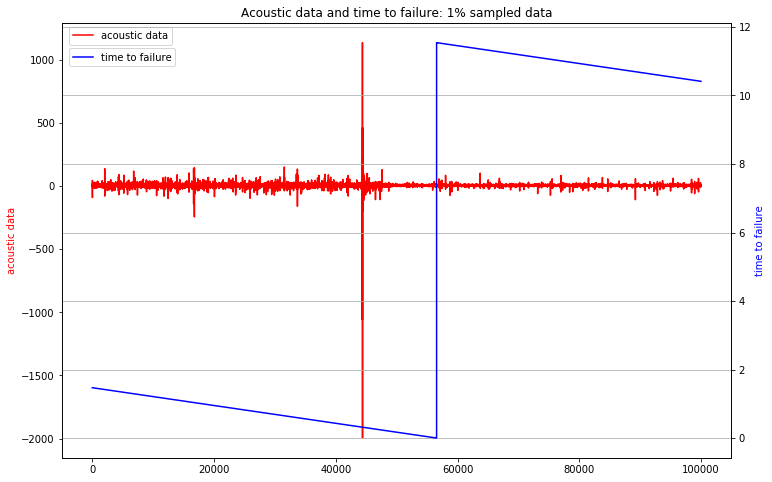

In [4]:
#visualize 1% of samples data, first 100 datapoints
train_ad_sample_df = train['acoustic_data'].values[::100]
train_ttf_sample_df = train['time_to_failure'].values[::100]

#function for plotting based on both features
def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

In [5]:
def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.quantile(X,0.01))
    strain.append(np.quantile(X,0.05))
    strain.append(np.quantile(X,0.95))
    strain.append(np.quantile(X,0.99))
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    return pd.Series(strain)

In [6]:
train.describe()

,acoustic_data,time_to_failure
count,1.000000e+07,1.000000e+07
mean,4.502072e+00,5.183598e+00
std,1.780707e+01,5.091286e+00
min,-4.621000e+03,7.954798e-04
25%,2.000000e+00,6.498971e-01
50%,4.000000e+00,1.298899e+00
75%,7.000000e+00,1.089170e+01
max,3.252000e+03,1.154080e+01


In [7]:
train = pd.read_csv('../input/train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
    ch = gen_features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))

In [8]:
train_pool = Pool(X_train, y_train)
model = CatBoostRegressor(iterations=10000, loss_function='MAE', boosting_type='Ordered')
model.fit(X_train, y_train, silent=True)
model.best_score_

{'learn': {'MAE': 1.7804224713035586}}